In [413]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns

In [311]:
df = pd.read_excel('sales.xlsx')

In [312]:
df.head(2)

,InvoiceNumber,ProductCode,ProductName,Quantity,InvoiceDate,UnitPrice,CustomerId,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom


In [313]:
df.shape

(525461, 8)

In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   InvoiceNumber  525461 non-null  object        
 1   ProductCode    525461 non-null  object        
 2   ProductName    522533 non-null  object        
 3   Quantity       525461 non-null  int64         
 4   InvoiceDate    525461 non-null  datetime64[ns]
 5   UnitPrice      525461 non-null  float64       
 6   CustomerId     417534 non-null  float64       
 7   Country        525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


## cleaning and preprocessing

In [315]:
# remove null customer id values

df_no_missing_CustomerId = df.copy()

In [316]:
null_indexes = df_no_missing_CustomerId[df_no_missing_CustomerId.CustomerId.isnull()].index

df_no_missing_CustomerId.drop(null_indexes, inplace=True)

In [317]:
df_no_missing_CustomerId.shape

(417534, 8)

In [318]:
# keep only one row per duplicate rows
df_no_duplicate = df_no_missing_CustomerId.copy()

In [319]:
df_no_duplicate.duplicated().sum()

6771

In [320]:
df_no_duplicate.drop_duplicates(inplace=True)

In [321]:
df_no_duplicate.shape

(410763, 8)

In [322]:
# remove prices not bigger than zero
df_no_missing_price = df_no_duplicate.copy()

In [323]:
df_no_missing_price = df_no_missing_price[df_no_missing_price.UnitPrice > 0]

In [324]:
df_no_missing_price.CustomerId=df_no_missing_price['CustomerId'].astype(int)
df_no_missing_price.CustomerId=df_no_missing_price['CustomerId'].astype(str)

In [325]:
df_no_missing_price.shape

(410732, 8)

In [326]:
total_orders = df_no_missing_price.groupby('InvoiceNumber').InvoiceNumber.count().count()

In [327]:
cancelled_orders = df_no_missing_price[df_no_missing_price.InvoiceNumber.str.match('C') == 1].groupby('InvoiceNumber').InvoiceNumber.count().count()

In [328]:
# calculate the percentage of cancelled orderes

percentage_cancelled_orders = round(cancelled_orders / total_orders * 100)
percentage_cancelled_orders

19

In [329]:
top_cancellings = df_no_missing_price[df_no_missing_price.InvoiceNumber.str.match('C') == 1].groupby('CustomerId').InvoiceNumber.count().nlargest(n=5)

In [330]:
# calculate the top 5 cancelling customers

top_cancelling_customers = list(top_cancellings.index)
top_cancelling_customers

['15311', '14911', '17511', '14680', '13798']

In [331]:
# remove the cancelled orderes
df_no_canceled_inovice = df_no_missing_price.copy()

In [332]:
canceled_indexes = df_no_canceled_inovice[df_no_canceled_inovice.InvoiceNumber.str.match('C') == 1].index
df_no_canceled_inovice.drop(canceled_indexes, inplace=True)

In [333]:
df_no_canceled_inovice.shape

(400916, 8)

In [334]:
# save the remaining invoice ids: 

remaining_invoices = pd.Series(df_no_canceled_inovice.InvoiceNumber.unique())
remaining_invoices

0        489434
1        489435
2        489436
3        489437
4        489438
          ...  
19208    538167
19209    538168
19210    538169
19211    538170
19212    538171
Length: 19213, dtype: object

In [335]:
df_preprocessed = df_no_canceled_inovice.copy()

## exploration

In [336]:
df_invoice = df_preprocessed.copy()

In [337]:
# calculate the number of remaining orders

number_of_orders = df_invoice.InvoiceNumber.nunique()
number_of_orders

19213

In [338]:
# calculate the period window

window_period = df_invoice.InvoiceDate.min(), df_invoice.InvoiceDate.max()
window_period

(Timestamp('2009-12-01 07:45:00'), Timestamp('2010-12-09 20:01:00'))

In [339]:
df_invoice['Invoice_day'] = pd.to_datetime(df_invoice.InvoiceDate).dt.day_name()

In [340]:
df_invoice_grouped = pd.DataFrame(df_invoice.groupby(['InvoiceNumber', 'Invoice_day']).InvoiceNumber.count())

In [341]:
df_invoice_grouped.head()

,,InvoiceNumber
InvoiceNumber,Invoice_day,
489434,Tuesday,8
489435,Tuesday,4
489436,Tuesday,19
489437,Tuesday,23
489438,Tuesday,17


In [342]:
df_invoice_numbers = df_invoice_grouped.groupby('Invoice_day').count().reset_index()

In [343]:
df_invoice_numbers

,Invoice_day,InvoiceNumber
0,Friday,2615
1,Monday,2986
2,Saturday,30
3,Sunday,2666
4,Thursday,3976
5,Tuesday,3514
6,Wednesday,3426


In [344]:
weekdays = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
Number_of_Invoices = [2986, 3514, 3426, 3976, 2615, 30, 2666]

C:\Users\HOME\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


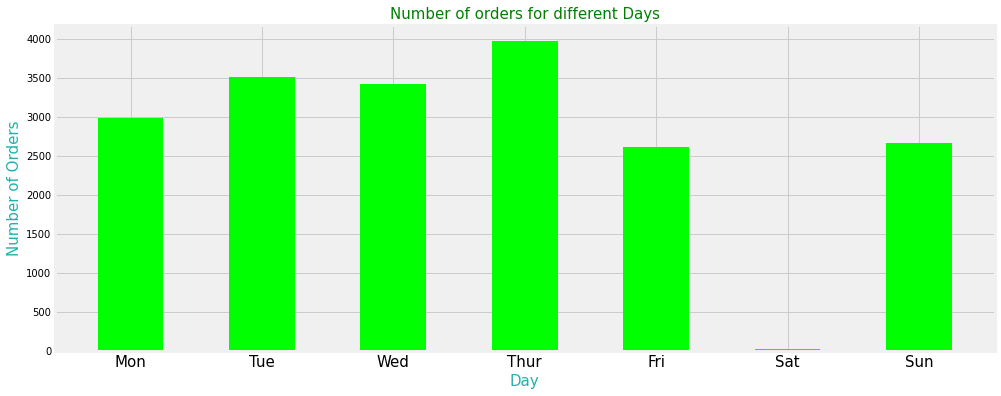

In [345]:
# plot the number of orders per week day

fig1 , ax1 = plt.subplots(figsize=(15,6))
ax1.bar(weekdays, Number_of_Invoices, color='lime', width=0.5)
ax1.set_title('Number of orders for different Days', fontsize=15, color='green')
ax1.set_xlabel('Day', fontsize=15, color='lightseagreen')
ax1.set_ylabel('Number of Orders', fontsize=15, color='lightseagreen')
ax1.set_xticklabels(weekdays, fontsize=15);

In [346]:
df_TotalPrices = df_invoice.copy()

In [347]:
df_TotalPrices['TotalPrices'] = df_TotalPrices['UnitPrice'] * df_TotalPrices['Quantity']

In [348]:
df_TotalPrices.head(1)

,InvoiceNumber,ProductCode,ProductName,Quantity,InvoiceDate,UnitPrice,CustomerId,Country,Invoice_day,TotalPrices
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,Tuesday,83.4


In [349]:
df_TotalPrices['Year_Month']=pd.to_datetime(df_TotalPrices['InvoiceDate']).dt.strftime('%y-%m')

In [350]:
df_Prices = df_TotalPrices.groupby('Year_Month').TotalPrices.sum().reset_index()

In [351]:
df_Prices

,Year_Month,TotalPrices
0,09-12,683504.010
1,10-01,555802.672
2,10-02,504558.956
3,10-03,696978.471
4,10-04,591982.002
5,10-05,597833.380
6,10-06,636371.130
7,10-07,589736.170
8,10-08,602224.600
9,10-09,829013.951


In [352]:
df_Prices['Year_Month'] = pd.to_datetime(df_Prices['Year_Month'], format=('%y-%m'))

In [353]:
df_Prices

,Year_Month,TotalPrices
0,2009-12-01,683504.010
1,2010-01-01,555802.672
2,2010-02-01,504558.956
3,2010-03-01,696978.471
4,2010-04-01,591982.002
5,2010-05-01,597833.380
6,2010-06-01,636371.130
7,2010-07-01,589736.170
8,2010-08-01,602224.600
9,2010-09-01,829013.951


In [354]:
df_Prices['Year_Month'] = df_Prices.Year_Month.dt.month_name().astype(str).str[:3] + "_" + df_Prices.Year_Month.dt.year.astype(str)

In [355]:
df_Prices

,Year_Month,TotalPrices
0,Dec_2009,683504.010
1,Jan_2010,555802.672
2,Feb_2010,504558.956
3,Mar_2010,696978.471
4,Apr_2010,591982.002
5,May_2010,597833.380
6,Jun_2010,636371.130
7,Jul_2010,589736.170
8,Aug_2010,602224.600
9,Sep_2010,829013.951


In [356]:
df_Prices.loc[7, 'Year_Month'] = 'July_2010'

In [357]:
df_Prices

,Year_Month,TotalPrices
0,Dec_2009,683504.010
1,Jan_2010,555802.672
2,Feb_2010,504558.956
3,Mar_2010,696978.471
4,Apr_2010,591982.002
5,May_2010,597833.380
6,Jun_2010,636371.130
7,July_2010,589736.170
8,Aug_2010,602224.600
9,Sep_2010,829013.951


In [358]:
df_Prices = df_Prices.set_index('Year_Month')

In [359]:
df_Prices

,TotalPrices
Year_Month,
Dec_2009,683504.010
Jan_2010,555802.672
Feb_2010,504558.956
Mar_2010,696978.471
Apr_2010,591982.002
May_2010,597833.380
Jun_2010,636371.130
July_2010,589736.170
Aug_2010,602224.600


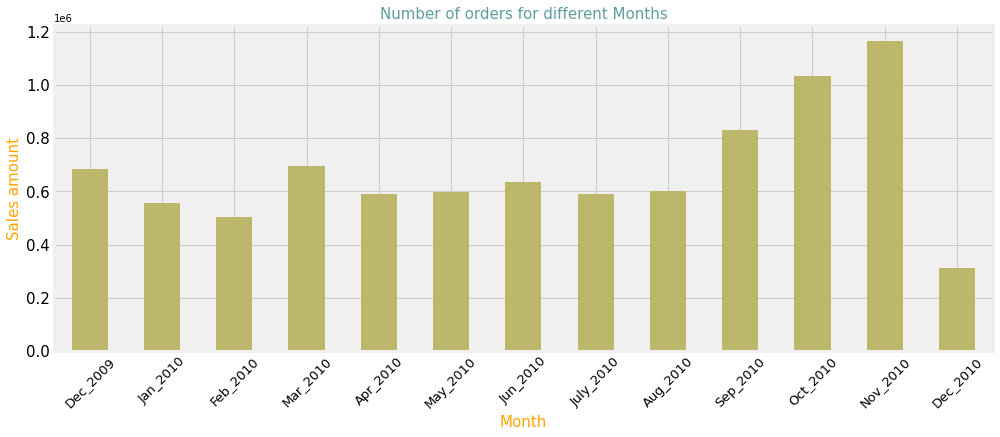

In [360]:
fig2 , ax2 = plt.subplots(figsize=(15,6))
df_Prices.plot(kind='bar', ax=ax2, color='darkkhaki', fontsize=15, legend=None)
ax2.set_title('Number of orders for different Months', fontsize=15, color='cadetblue')
ax2.set_xlabel('Month', fontsize=15, color='orange')
ax2.set_ylabel('Sales amount', fontsize=15, color='orange')
ax2.set_xticklabels(df_Prices.index, fontsize=13, rotation=45);

## market study

In [361]:
df_market = df_preprocessed.copy()

In [362]:
df_market['TotalPrice'] = df_market['Quantity'] * df_market['UnitPrice']

In [363]:
df_market.head(1)

,InvoiceNumber,ProductCode,ProductName,Quantity,InvoiceDate,UnitPrice,CustomerId,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4


In [364]:
df_country = pd.DataFrame(df_market.groupby('Country').CustomerId.nunique())

In [365]:
df_country.head()

,CustomerId
Country,
Australia,15
Austria,10
Bahrain,2
Belgium,17
Brazil,1


In [366]:
df_country.columns=['CC']

In [367]:
df_country['SA'] = df_market.groupby('Country').TotalPrice.sum()

In [368]:
df_country.head(1)

,CC,SA
Country,,
Australia,15,31446.8


In [369]:
q3CC = np.percentile(df_country.CC, 75)
q3SA = np.percentile(df_country.SA, 75)

def grouping(x):
    if x.CC < q3CC and x.SA < q3SA:
        x['Group'] = 'Low customer & revenue'
        
    elif x.CC >= q3CC and x.SA < q3SA:
        x['Group'] = 'High customer & low revenue'
        
    elif x.CC < q3CC and x.SA >= q3SA:
        x['Group'] = 'High revenue & low customer'
        
    else:
        x['Group'] = 'Highest customer & revenue'
    
    return x

In [370]:
q3CC, q3SA

(14.0, 31446.8)

In [371]:
df_country = df_country.apply(grouping, axis=1)

In [372]:
df_country

,CC,SA,Group
Country,,,
Australia,15.0,31446.800,Highest customer & revenue
Austria,10.0,13414.330,Low customer & revenue
Bahrain,2.0,805.970,Low customer & revenue
Belgium,17.0,24537.580,High customer & low revenue
Brazil,1.0,268.270,Low customer & revenue
Canada,1.0,1216.660,Low customer & revenue
Channel Islands,11.0,24546.320,Low customer & revenue
Cyprus,7.0,11347.100,Low customer & revenue
Denmark,9.0,50906.850,High revenue & low customer


In [373]:
df_country.drop('United Kingdom', inplace=True)

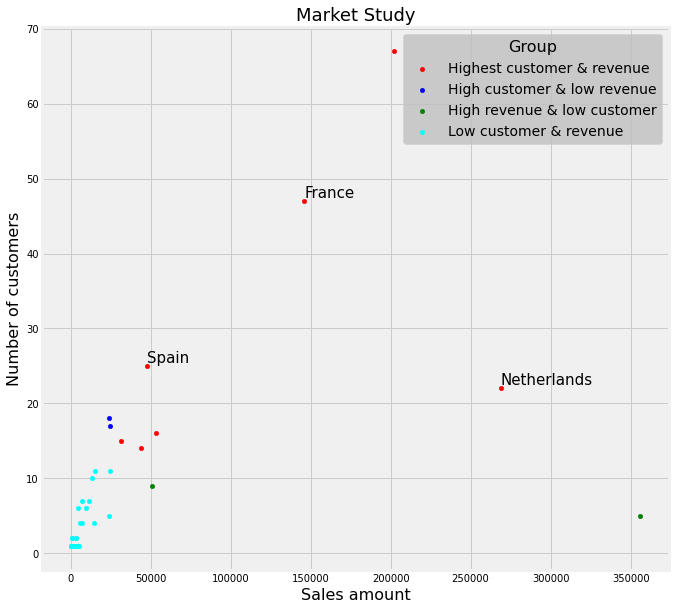

In [374]:
# plot

fig , ax = plt.subplots(figsize=(10,10))
plt.style.use('fivethirtyeight')

colors={'Highest customer & revenue': 'red', 'High customer & low revenue': 'blue', 'High revenue & low customer': 'green', 'Low customer & revenue': 'cyan'}

group_labels = [key for key, value in colors.items()]

for label in group_labels:
    df_subset = df_country[df_country['Group'] == label]
    df_subset.plot(x='SA', y='CC', kind='scatter', ax=ax, c=colors[label], label=label, s=20)

ax.set_title('Market Study', fontsize=18)
ax.set_xlabel('Sales amount', fontsize=16)
ax.set_ylabel('Number of customers', fontsize=16)
ax.legend(fontsize=14, frameon=True, facecolor='silver', title='Group', title_fontsize=16)

ax.annotate('Spain', xy=(df_country.loc['Spain', 'SA'], df_country.loc['Spain', 'CC']), xytext=(df_country.loc['Spain', 'SA'], df_country.loc['Spain', 'CC']+0.5), fontsize=15)
ax.annotate('France', xy=(df_country.loc['France', 'SA'], df_country.loc['France', 'CC']), xytext=(df_country.loc['France', 'SA'], df_country.loc['France', 'CC']+0.5), fontsize=15)
ax.annotate('Netherlands', xy=(df_country.loc['Netherlands', 'SA'], df_country.loc['Netherlands', 'CC']), xytext=(df_country.loc['Netherlands', 'SA'], df_country.loc['Netherlands', 'CC']+0.5), fontsize=15);


## customer valuation 

In [393]:
df_Date = df_preprocessed.copy()

In [394]:
df_Date['InvoiceDate'] = pd.to_datetime(df_Date.InvoiceDate)

In [395]:
df_Date['TotalPrice'] = df_Date['UnitPrice'] * df_Date['Quantity']

In [396]:
df_customer = pd.DataFrame(df_Date.groupby('CustomerId').InvoiceDate.max())

In [397]:
df_customer['Recency'] = (df_customer.InvoiceDate.max() - df_customer.InvoiceDate).dt.days + 1

In [398]:
df_customer['Frequency'] = ((pd.DataFrame(df_Date.groupby(['CustomerId', 'InvoiceNumber']).count())).reset_index()).groupby('CustomerId').InvoiceNumber.count()

In [399]:
df_customer['Monetary_value'] =  df_Date.groupby('CustomerId').TotalPrice.sum()

In [400]:
df_customer.head(5)

,InvoiceDate,Recency,Frequency,Monetary_value
CustomerId,,,,
12346,2010-06-28 13:53:00,165,11,372.86
12347,2010-12-07 14:57:00,3,2,1323.32
12348,2010-09-27 14:59:00,74,1,222.16
12349,2010-10-28 08:23:00,43,3,2671.14
12351,2010-11-29 15:23:00,11,1,300.93


In [401]:
q1R = np.percentile(df_customer.Recency, 25)
q2R = np.percentile(df_customer.Recency, 50)
q3R = np.percentile(df_customer.Recency, 75)

df_customer['R_quartile'] = df_customer.Recency.apply(lambda x: 1 if x<=q1R else 2 if x<=q2R else 3 if x<=q3R else 4)

In [402]:
q1F = np.percentile(df_customer.Frequency, 25)
q2F = np.percentile(df_customer.Frequency, 50)
q3F = np.percentile(df_customer.Frequency, 75)

df_customer['F_quartile'] = df_customer.Frequency.apply(lambda x: 1 if x<=q1F else 2 if x<=q2F else 3 if x<=q3F else 4)

In [403]:
q1M = np.percentile(df_customer.Monetary_value, 25)
q2M = np.percentile(df_customer.Monetary_value, 50)
q3M = np.percentile(df_customer.Monetary_value, 75)

df_customer['M_quartile'] = df_customer.Monetary_value.apply(lambda x: 1 if x<=q1M else 2 if x<=q2M else 3 if x<=q3M else 4)

In [404]:
df_customer.head(1)

,InvoiceDate,Recency,Frequency,Monetary_value,R_quartile,F_quartile,M_quartile
CustomerId,,,,,,,
12346,2010-06-28 13:53:00,165,11,372.86,4,4,2


In [405]:
df_customer['RFM'] = df_customer['R_quartile'].astype(str) + df_customer['F_quartile'].astype(str) + df_customer['M_quartile'].astype(str)

In [406]:
df_customer.head(1)

,InvoiceDate,Recency,Frequency,Monetary_value,R_quartile,F_quartile,M_quartile,RFM
CustomerId,,,,,,,,
12346,2010-06-28 13:53:00,165,11,372.86,4,4,2,442


In [407]:
def Segmentor(x):
    if x == '144':
        return 'Best'
    elif x == '344':
        return 'AlmostLost'
    elif x == '444':
        return 'LostBigSpenders'
    elif x == '441':
        return 'LostCheap'
    elif x[1] == '4':
        return 'Loyal'       
    elif x[2] == '4':
        return 'BigSpenders'
    else:
        return 'Normal'

In [408]:
df_customer['Segment'] = df_customer.RFM.apply(Segmentor)

In [409]:
df_customer

,InvoiceDate,Recency,Frequency,Monetary_value,R_quartile,F_quartile,M_quartile,RFM,Segment
CustomerId,,,,,,,,,
12346,2010-06-28 13:53:00,165,11,372.86,4,4,2,442,Loyal
12347,2010-12-07 14:57:00,3,2,1323.32,1,2,3,123,Normal
12348,2010-09-27 14:59:00,74,1,222.16,3,1,1,311,Normal
12349,2010-10-28 08:23:00,43,3,2671.14,2,3,4,234,BigSpenders
12351,2010-11-29 15:23:00,11,1,300.93,1,1,1,111,Normal
...,...,...,...,...,...,...,...,...,...
18283,2010-11-22 15:30:00,18,6,619.37,1,4,2,142,Loyal
18284,2010-10-04 11:33:00,67,1,461.68,3,1,2,312,Normal
18285,2010-02-17 10:24:00,296,1,427.00,4,1,2,412,Normal


In [410]:
df_customer.groupby('Segment').Segment.count()

Segment
AlmostLost           98
Best                440
BigSpenders         321
LostBigSpenders      16
LostCheap             1
Loyal               387
Normal             3049
Name: Segment, dtype: int64

In [411]:
df_customer_segments = df_customer['Segment'].reset_index()

In [412]:
df_customer_segments

,CustomerId,Segment
0,12346,Loyal
1,12347,Normal
2,12348,Normal
3,12349,BigSpenders
4,12351,Normal
...,...,...
4307,18283,Loyal
4308,18284,Normal
4309,18285,Normal
4310,18286,Normal


## retention rate

In [414]:
df_customer_retention = df_preprocessed.copy()

In [415]:
df_customer_retention = df_customer_retention.loc[:, ['InvoiceDate', 'CustomerId']]

In [416]:
df_customer_retention['InvoiceDate'] = pd.to_datetime(pd.to_datetime(df_customer_retention.InvoiceDate).dt.strftime('%Y-%m'))

In [417]:
df_customer_retention = df_customer_retention.groupby(['InvoiceDate', 'CustomerId']).count()

In [419]:
df_customer_retention = df_customer_retention.reset_index(level='CustomerId')

In [420]:
df_customer.head(1)

,InvoiceDate,Recency,Frequency,Monetary_value,R_quartile,F_quartile,M_quartile,RFM,Segment
CustomerId,,,,,,,,,
12346,2010-06-28 13:53:00,165,11,372.86,4,4,2,442,Loyal


In [421]:
df_customer.index.unique()

Index(['12346', '12347', '12348', '12349', '12351', '12352', '12353', '12355',
       '12356', '12357',
       ...
       '18277', '18278', '18279', '18280', '18281', '18283', '18284', '18285',
       '18286', '18287'],
      dtype='object', name='CustomerId', length=4312)

In [422]:
month_list = ['2009-12-01', '2010-01-01', '2010-02-01', '2010-03-01',
               '2010-04-01', '2010-05-01', '2010-06-01', '2010-07-01',
               '2010-08-01', '2010-09-01', '2010-10-01', '2010-11-01',
               '2010-12-01']

In [423]:
month_customers = []
for i in range(13):
    month_customers.append(list(df_customer_retention.loc[month_list[i], 'CustomerId'].unique()))

In [424]:
first_time_customers = []
union_list = []
for i in range(0, 13):
    first_time_customers.append(list(set(month_customers[i]).difference(union_list)))
    union_list = list(set(union_list + month_customers[i]))

In [425]:
retention =[]

for i in range(13):
    L=[]
    for j in range(i,13):
        L.append(round((len(set(first_time_customers[i]) & set(month_customers[j])) / len(set(first_time_customers[i])) * 100)))
    retention.append(L)

In [426]:
retention

[[100, 35, 33, 43, 38, 36, 38, 34, 34, 36, 42, 50, 25],
 [100, 21, 31, 31, 26, 30, 26, 23, 28, 32, 30, 10],
 [100, 24, 22, 29, 25, 20, 19, 29, 25, 28, 7],
 [100, 19, 23, 24, 23, 20, 25, 30, 28, 8],
 [100, 19, 19, 16, 18, 22, 28, 26, 7],
 [100, 16, 17, 17, 18, 26, 21, 8],
 [100, 17, 19, 20, 23, 29, 7],
 [100, 16, 18, 30, 29, 10],
 [100, 20, 30, 32, 12],
 [100, 23, 23, 10],
 [100, 26, 9],
 [100, 11],
 [100]]

In [431]:
retention_matrix = np.zeros((13,13))

In [432]:
retention_matrix[:] = np.nan

In [433]:
for i in range(13):
    for j in range(13-i):
        retention_matrix[i][j] = retention[i][j]

In [434]:
df_retention = pd.DataFrame(retention_matrix, columns=range(1,14), index=month_list)

In [435]:
df_retention

,1,2,3,4,5,6,7,8,9,10,11,12,13
2009-12-01,100.0,35.0,33.0,43.0,38.0,36.0,38.0,34.0,34.0,36.0,42.0,50.0,25.0
2010-01-01,100.0,21.0,31.0,31.0,26.0,30.0,26.0,23.0,28.0,32.0,30.0,10.0,NaN
2010-02-01,100.0,24.0,22.0,29.0,25.0,20.0,19.0,29.0,25.0,28.0,7.0,NaN,NaN
2010-03-01,100.0,19.0,23.0,24.0,23.0,20.0,25.0,30.0,28.0,8.0,NaN,NaN,NaN
2010-04-01,100.0,19.0,19.0,16.0,18.0,22.0,28.0,26.0,7.0,NaN,NaN,NaN,NaN
2010-05-01,100.0,16.0,17.0,17.0,18.0,26.0,21.0,8.0,NaN,NaN,NaN,NaN,NaN
2010-06-01,100.0,17.0,19.0,20.0,23.0,29.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,100.0,16.0,18.0,30.0,29.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,100.0,20.0,30.0,32.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-01,100.0,23.0,23.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


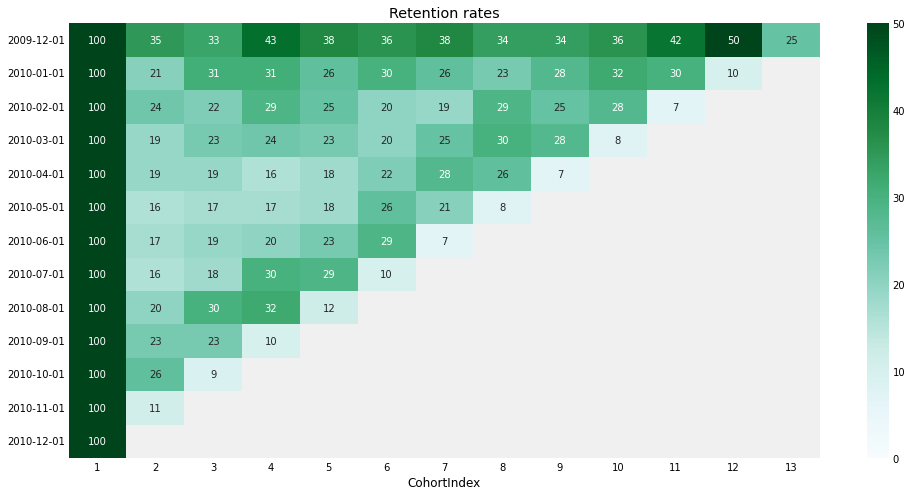

In [436]:
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(df_retention, annot=True, cmap='BuGn', vmax=50, vmin=0, fmt='.0f', mask=df_retention==0)
ax.set_title('Retention rates')
ax.set_xlabel('CohortIndex');